In [1]:
import calendar
import json
import os
import time
import traceback
from datetime import datetime

import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import requests
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

palette = sns.color_palette("colorblind", 20)

spark = (
    SparkSession.builder
        .master("local")
        .appName("TFL Notebook")
        .getOrCreate()
)

trips = spark.read.parquet("data/parquet_trip")

trips.limit(10).toPandas()


,rental_id,duration,bike_id,end_station_id,end_station_name,start_station_id,start_station_name,start_ts,start_year,start_month,start_day,start_day_of_week,start_hour,end_ts,end_year,end_month,end_day,end_day_of_week,end_hour
0,61460085,660,139,819,"Belvedere Road 2, South Bank",217,"Wormwood Street, Liverpool Street",2017-01-05 07:04:00,2017,1,5,5,7,2017-01-05 07:15:00,2017,1,5,5,7
1,61449020,660,6359,217,"Wormwood Street, Liverpool Street",819,"Belvedere Road 2, South Bank",2017-01-04 16:05:00,2017,1,4,4,16,2017-01-04 16:16:00,2017,1,4,4,16
2,61437158,600,14302,819,"Belvedere Road 2, South Bank",217,"Wormwood Street, Liverpool Street",2017-01-04 07:17:00,2017,1,4,4,7,2017-01-04 07:27:00,2017,1,4,4,7
3,61473622,660,8877,217,"Wormwood Street, Liverpool Street",273,"Belvedere Road 1, South Bank",2017-01-05 16:02:00,2017,1,5,5,16,2017-01-05 16:13:00,2017,1,5,5,16
4,61484961,600,5700,819,"Belvedere Road 2, South Bank",217,"Wormwood Street, Liverpool Street",2017-01-06 07:16:00,2017,1,6,6,7,2017-01-06 07:26:00,2017,1,6,6,7
5,61482672,420,13720,246,"Berry Street, Clerkenwell",433,"Wren Street, Holborn",2017-01-05 21:05:00,2017,1,5,5,21,2017-01-05 21:12:00,2017,1,5,5,21
6,61482473,420,13720,433,"Wren Street, Holborn",594,"Kingsway Southbound, Strand",2017-01-05 20:45:00,2017,1,5,5,20,2017-01-05 20:52:00,2017,1,5,5,20
7,61470321,480,12610,162,"Southampton Place, Holborn",246,"Berry Street, Clerkenwell",2017-01-05 13:00:00,2017,1,5,5,13,2017-01-05 13:08:00,2017,1,5,5,13
8,61447445,540,11477,358,"High Holborn , Covent Garden",246,"Berry Street, Clerkenwell",2017-01-04 14:22:00,2017,1,4,4,14,2017-01-04 14:31:00,2017,1,4,4,14
9,61495906,360,10616,427,"Cheapside, Bank",66,"Holborn Circus, Holborn",2017-01-06 14:01:00,2017,1,6,6,14,2017-01-06 14:07:00,2017,1,6,6,14


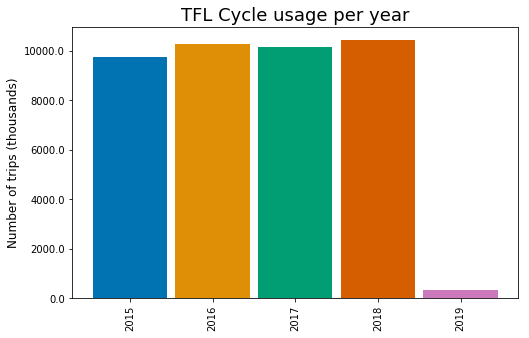

In [2]:
trips.createOrReplaceTempView("trips")
sdf = spark.sql("""
    select start_year, count(*) as cnt
    from trips 
    group by start_year
    order by start_year asc
""")

df = sdf.toPandas()

ax = df.plot(kind='bar', color=palette, legend=None, x='start_year', y='cnt', width=0.9, figsize=(8,5))
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x)/1000)))
plt.title("TFL Cycle usage per year", fontsize=18)
plt.ylabel("Number of trips (thousands)", fontsize=12)
plt.xlabel('')
plt.show()

/Users/dant/Development/tfl-cycles/venv/lib/python3.7/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


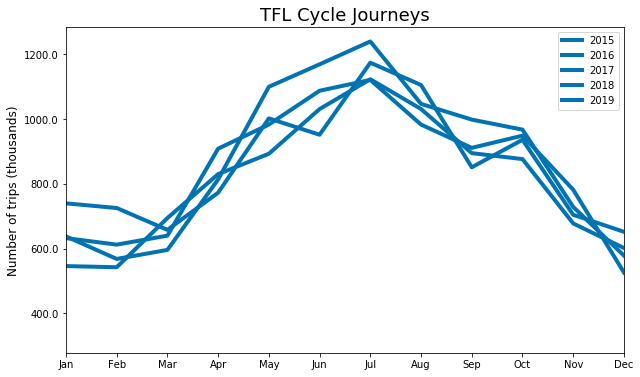

In [10]:
trips.createOrReplaceTempView("trips")
sdf = spark.sql("""
    select start_year, start_month, count(*) as cnt, avg(duration) as duration 
    from trips 
    group by start_year, start_month
    order by start_year asc, start_month asc
""")

df = sdf.toPandas()

fig, ax = plt.subplots(figsize=(10, 6))
plt.xticks(range(0,13), calendar.month_abbr)

ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x)/1000)))

for key, grp in df.groupby(['start_year']):
    ax = grp.plot(ax=ax, kind='line', x='start_month', y='cnt', label=key, linewidth=4.0)

plt.title("TFL Cycle Journeys", fontsize=18)
plt.xlabel('')
plt.ylabel('Number of trips (thousands)', fontsize=12)
plt.legend(loc='best')
plt.show()


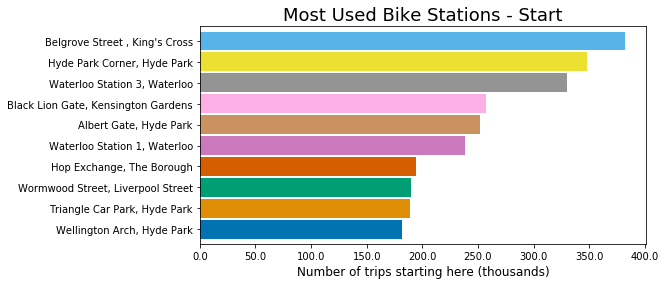

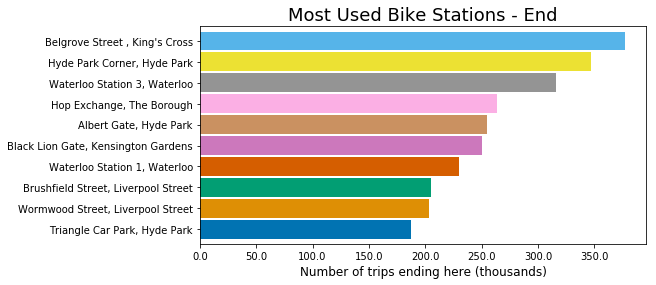

In [4]:
trips.createOrReplaceTempView("trips")
start_df = spark.sql("""
    select start_station_name, count(*) as cnt
    from trips 
    group by start_station_name
    order by cnt desc
""").limit(10).toPandas()

start_df = start_df.sort_values(by=['cnt'], ascending=True)

ax = start_df.plot(kind='barh', color=palette, legend=None, x='start_station_name', y='cnt', width=0.9, figsize=(8,4))
ax.get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x)/1000)))
plt.title("Most Used Bike Stations - Start", fontsize=18)
plt.xlabel("Number of trips starting here (thousands)", fontsize=12)
plt.ylabel('')
plt.show()

trips.createOrReplaceTempView("trips")
end_df = spark.sql("""
    select end_station_name, count(*) as cnt
    from trips 
    group by end_station_name
    order by cnt desc
""").limit(10).toPandas()

end_df = end_df.sort_values(by=['cnt'], ascending=True)

ax = end_df.plot(kind='barh', color=palette, legend=None, x='end_station_name', y='cnt', width=0.9, figsize=(8,4))
ax.get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x)/1000)))
plt.title("Most Used Bike Stations - End", fontsize=18)
plt.xlabel("Number of trips ending here (thousands)", fontsize=12)
plt.ylabel('')
plt.show()

In [5]:
trips.createOrReplaceTempView("trips")
trip_counts = spark.sql("""
    select start_station_name, end_station_name, count(*) as trip_count, sum(duration) as duration
    from trips 
    group by start_station_name, end_station_name
    order by trip_count desc
""")

# Would be nice: https://plot.ly/python/filled-chord-diagram/

trip_counts.limit(10).toPandas()

,start_station_name,end_station_name,trip_count,duration
0,"Hyde Park Corner, Hyde Park","Hyde Park Corner, Hyde Park",93560,313209592
1,"Albert Gate, Hyde Park","Albert Gate, Hyde Park",51747,149918311
2,"Black Lion Gate, Kensington Gardens","Black Lion Gate, Kensington Gardens",50354,162591998
3,"Aquatic Centre, Queen Elizabeth Olympic Park","Aquatic Centre, Queen Elizabeth Olympic Park",48171,170272978
4,"Triangle Car Park, Hyde Park","Triangle Car Park, Hyde Park",39287,116969845
5,"Park Lane , Hyde Park","Park Lane , Hyde Park",27167,95763993
6,"Palace Gate, Kensington Gardens","Palace Gate, Kensington Gardens",24332,69244229
7,"Hyde Park Corner, Hyde Park","Albert Gate, Hyde Park",19225,52035533
8,"Wellington Arch, Hyde Park","Wellington Arch, Hyde Park",19157,55263060
9,"Black Lion Gate, Kensington Gardens","Palace Gate, Kensington Gardens",19080,28927278


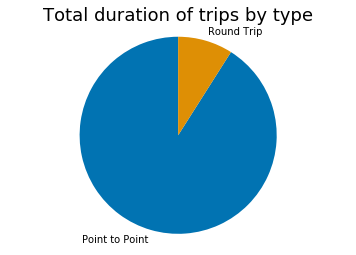

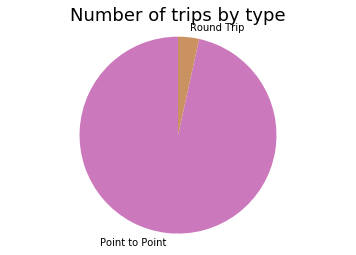

In [8]:
trip_counts.createOrReplaceTempView("trip_counts")
trips_by_type = spark.sql("""
    select start_station_name, end_station_name, trip_count, duration,
    CASE WHEN start_station_name = end_station_name THEN "Round Trip" ELSE "Point to Point" END AS trip_type
    from trip_counts
""")

trips_by_type.createOrReplaceTempView("trips_by_type")
df = (
    spark.sql("""
        select trip_type, sum(trip_count) as trip_count, sum(duration) as duration from trips_by_type
        group by trip_type
    """)
).toPandas()

plt.pie(df['duration'], labels=df['trip_type'], shadow=False, colors=palette, startangle=90)
plt.title("Total duration of trips by type", fontsize=18)
plt.axis('equal')
plt.show()

plt.pie(df['trip_count'], labels=df['trip_type'], shadow=False, colors=palette[4:], startangle=90)
plt.title("Number of trips by type", fontsize=18)
plt.axis('equal')
plt.show()